# Développement d'un algorithme en Spark

# Objectif du Notebook
Il s'agit de développer en Spark une méthode de gradient, dans le but de résoudre un problème de filtrage collaboratif, et de la comparer avec une méthode de la librairie MLIB. Ce Notebook a pour but le développement et la validation de l'approche, avant intégration et exploitation dans le cadre de l'infrastructure développée dans le projet. Pour information, de nombreuses versions de ce problème existent sur le web.

# Position du problème
Nous avons à notre disposition un RDD "ratings" du type (userID, movieID, rating). Les données sont fournies par le fichier `ratings.dat`, stockées  au format ci-joint :
```
UserID::MovieID::Rating::Timestamp
```

Ce RDD peut être stocké dans une matrice $R$ où l'on trouve "rating" à l'intersection de la ligne "userID" et de la colonne "movieID".
Si la matrice $R$ est de taille $m \times  n$, nous cherchons $P \in R^{m,k}$ et $Q \in R^{n,k}$ telles que $R \approx \hat{R} = PQ^T$.
Pour cela on considère le problème
$$ \min_{P,Q} \sum_{i,j : r_{ij} \text{existe}}  \ell_{i,j}(R,P,Q), $$
où
$$  \ell_{i,j}(R,P,Q)= \left(r_{ij} - q_{j}^{\top}p_{i}\right)^2 + \lambda(|| p_{i} ||^{2}_2 + || q_{j} ||^2_2 )  $$ et $(p_i)_{1\leq i\leq m}$ et $(q_j)_{1\leq j\leq n}$ sont les lignes des matrices $P$ et $Q$ respectivement. Le paramètre $\lambda\geq 0$ est un paramètre de régularisation.

Le problème que nous résolvons ici est un problème dit de "filtrage collaboratif", qui permet d'apporter une solution possible du  problème Netflix.


In [1]:
# Librairies
import numpy as np
from scipy import sparse

# Environnement Spark 
from pyspark import SparkContext, SparkConf

# A modifier/commenter selon votre configuration.
# import os
# os.environ['PYSPARK_PYTHON'] = '/usr/local/bin/python3.7'

conf = SparkConf()
conf.setMaster("local[*]")
conf.setAppName("Matrix Factorization")

sc = SparkContext(conf = conf)


#### Création du RDD et premières statistiques sur le jeu de données.

In [2]:
# Répertoire contenant le jeu de données
movieLensHomeDir="data/"

# ratings est un RDD du type (userID, movieID, rating)
def parseRating(line):
    fields = line.split('::')
    return int(fields[0]), int(fields[1]), float(fields[2])

ratingsRDD = sc.textFile(movieLensHomeDir + "ratings.dat").map(parseRating).setName("ratings").cache()

# Calcul du nombre de ratings
numRatings = ratingsRDD.count()
# Calcul du nombre d'utilisateurs distincts
numUsers = ratingsRDD.map(lambda r: r[0]).distinct().count()
# Calcul du nombre de films distincts
numMovies = ratingsRDD.map(lambda r: r[1]).distinct().count()
print("We have %d ratings from %d users on %d movies.\n" % (numRatings, numUsers, numMovies))

# Dimensions de la matrice R
M = ratingsRDD.map(lambda r: r[0]).max()
N = ratingsRDD.map(lambda r: r[1]).max()
matrixSparsity = float(numRatings)/float(M*N)
print("We have %d users, %d movies and the rating matrix has %f percent of non-zero value.\n" % (M, N, 100*matrixSparsity))

We have 1000209 ratings from 6040 users on 3706 movies.

We have 6040 users, 3952 movies and the rating matrix has 4.190221 percent of non-zero value.



Nous allons utiliser la routine ALS.train() de la librairie  [MLLib](http://spark.apache.org/docs/latest/ml-guide.html) et en évaluer la performance par un calcul de " Mean Squared Error" du  rating de prédiction.

__Question 1__

> Commenter les lignes de code suivantes en vous inspirant du code python http://spark.apache.org/docs/latest/mllib-collaborative-filtering.html#collaborative-filtering



In [3]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

# Construction du modèle de recommendations depuis l'approche "Alternating Least Squares"
rank = 10
numIterations = 10

# Paramètres de la méthode Alternating Least Squares (ALS)
# ratings – RDD de Rating ou tuple (userID, productID, rating).
# rank – Rang de la matrice modèle.
# iterations – Nombre d'itérations. (default: 5)
# lambda_ – Paramètre de régularisation. (default: 0.01)
model = ALS.train(ratingsRDD, rank, iterations=numIterations, lambda_=0.02)

# Evaluation du modèle sur le jeu de données complet
testdata = ratingsRDD.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = ratingsRDD.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 0.586562752212026


#  Algorithmes de descente de gradient

Le but de cette section est  
1. de calculer le gradient de la fonction,
2. d'implémenter une méthode de gradient,
3. de mesurer la précision de cette méthode

__Question 2__

> Séparer le jeu de données en un jeu d'apprentissage (70%) et un jeu de test, en utilisant la fonction randomsplit ( http://spark.apache.org/docs/2.0.0/api/python/pyspark.html )

> Compléter la routine ci-dessous qui retourne le "rating" prédit. Créer un RDD contenant `(i,j,true rating,predicted rating)`. 

> Compléter la routine qui calcule le Mean Square Error (MSE) sur le jeu de données.

> Tester ensuite la routine de MSE en vous donnant les matrices $P$ et $Q$ aléatoires (utiliser np.random.rand(M,K)) et calculer quelques "ratings" prédits. 



In [4]:
# Séparation du jeu de données en un jeu d'apprentissage et un jeu de test
# Taille du jeu d'apprentissage (en %) 
learningWeight = 0.7
trainRDD, testRDD = ratingsRDD.randomSplit([learningWeight, 1.0-learningWeight])
# Création des RDD "apprentissage" et "test" depuis la fonction randomsplit


# Calcul du rating préduit.
def predictedRating(x, P, Q):
    """ 
    This function computes predicted rating
    Args:
        x: tuple (UserID, MovieID, Rating)
        P: user's features matrix (M by K)
        Q: item's features matrix (N by K)
    Returns:
        predicted rating: l 
    """
    (i , j) = (x[0],x[1])
    return np.dot(P[i-1,:],Q[j-1,:])

# Calcul de l'erreur MSE 
def computeMSE(rdd, P, Q):
    """ 
    This function computes Mean Square Error (MSE)
    Args:
        rdd: RDD(UserID, MovieID, Rating)
        P: user's features matrix (M by K)
        Q: item's features matrix (N by K)
    Returns:
        mse: mean square error 
    """ 
    return rdd.map(lambda x: (x[2]-predictedRating(x, P, Q))**2).mean()

In [5]:
# Tailles des jeux de données d'apprentissage et de tests.
print("Size of the training dataset:", trainRDD.count())
print("Size of the testing dataset:", testRDD.count())


# Création de matrices aléatoires de dimension (M,K) et (N,K)
K = 20 
P = np.random.rand(M,K)
Q = np.random.rand(N,K)

# Calcul et affichage de l'erreur MSE pour ces matrices aléatoires
MSE = computeMSE(testRDD, P, Q)
print("Mean Squared Error = " + str(MSE))


# Affichage de quelques ratings prédits depuis ces matrices
predictedRatings = testRDD.map(lambda x: (x[0], x[1], predictedRating(x, P, Q)))
print("Some of the predicted Rating : \n %s" % predictedRatings.take(10))

Size of the training dataset: 700397
Size of the testing dataset: 299812
Mean Squared Error = 4.375645106139738
Some of the predicted Rating : 
 [(1, 1193, 5.420878682809534), (1, 914, 5.702916356155389), (1, 3105, 6.2614992169888835), (1, 527, 6.696552275589735), (1, 48, 6.321369998774065), (1, 3186, 4.98065235633358), (1, 588, 4.791302194894254), (1, 1022, 4.415303382315418), (1, 2762, 5.136077157546945), (1, 1962, 5.069575594734503)]


__Question 3__

> Donner la formule des dérivées des fonctions $\ell_{i,j}$ selon $p_t$ et $q_s$ avec $1\leq t\leq m$ et $1\leq s\leq n$.

> Commenter et compléter l'implantation de l'algorithme de gradient sur l'ensemble d'apprentissage. Prendre un pas égal à $\gamma=0.001$ et arrêter sur un nombre maximum d'itérations. 

> Commenter les tracés de convergence et des indicateurs de qualité de la prévision en fonction de la dimension latente (rang de $P$ et $Q$).

In [6]:
# Algorithem de descente de gradient pour la factorisation de matrices
def GD(trainRDD, K=10, MAXITER=50, GAMMA=0.001, LAMBDA=0.05):
    # Construction de la matrice R (creuse)
    row=[]
    col=[]
    data=[]
    for part in trainRDD.collect():
        row.append(part[0]-1)
        col.append(part[1]-1)
        data.append(part[2])
    R=sparse.csr_matrix((data, (row, col)))
    
    # Initialisation aléatoire des matrices P et Q
    M,N = R.shape
    P = np.random.rand(M,K)
    Q = np.random.rand(N,K)
    
    # Calcul de l'erreur MSE initiale
    mse=[]
    mse_tmp = computeMSE(trainRDD, P, Q)
    mse.append([0, mse_tmp])
    print("epoch: ", str(0), " - MSE: ", str(mse_tmp))
    
    # Boucle
    nonzero = R.nonzero()
    nbNonZero = R.nonzero()[0].size
    I,J = nonzero[0], nonzero[1]
    for epoch in range(MAXITER):
        for i,j in zip(I,J):
            # Mise à jour de P[i,:] et Q[j,:] par descente de gradient à pas fixe
            Eij = R[i,j] - np.dot(P[i,:],Q[j,:])
            P[i,:] = P[i,:] + 2*GAMMA*(Eij*Q[j,:] - LAMBDA*P[i,:])
            Q[j,:] = Q[j,:] + 2*GAMMA*(Eij*P[i,:] - LAMBDA*Q[j,:])
        
        # Calcul de l'erreur MSE courante, et sauvegarde dans le tableau mse 
        mse_tmp = computeMSE(trainRDD, P, Q)
        mse.append([epoch+1, mse_tmp])
        print("epoch: ", str(epoch+1), " - MSE: ", str(mse_tmp))
        
    return P, Q, mse

In [7]:
# Calcul de P, Q et de la mse
P,Q,mse = GD(trainRDD, K=10, MAXITER=10, GAMMA=0.001, LAMBDA=0.05)

epoch:  0  - MSE:  2.905478286423542
epoch:  1  - MSE:  1.027432848984649
epoch:  2  - MSE:  0.8998461108121617
epoch:  3  - MSE:  0.8639761773089086
epoch:  4  - MSE:  0.8459570182030849
epoch:  5  - MSE:  0.8350692043202209
epoch:  6  - MSE:  0.8277978114386827
epoch:  7  - MSE:  0.8226073264885876
epoch:  8  - MSE:  0.8187123511766671
epoch:  9  - MSE:  0.815668179044345
epoch:  10  - MSE:  0.8132042224804162


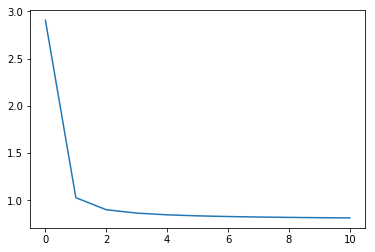

In [8]:
import matplotlib.pyplot as plt 

# Affichage de l'erreur MSE
%matplotlib inline  
list_MSE = []
for m in mse :
    list_MSE.append(m[1])

plt.plot(list_MSE)


__Question 4__

> Calculer les ratings prédits par la solution de la méthode du gradient dans un RDD

> Comparer sur le jeu de test les valeurs prédites aux ratings sur 5 échantillons aléatoires.

In [9]:
# Calcul et affichage des ratings prédits
predictedRatings = testRDD.map(lambda x: (x[0], x[1], x[2], predictedRating(x, P, Q)))
predictedRatings.take(5)


[(1, 1193, 5.0, 4.651834651543626),
 (1, 914, 3.0, 4.343361230382609),
 (1, 3105, 5.0, 3.9343383655736113),
 (1, 527, 5.0, 4.624840870170666),
 (1, 48, 5.0, 3.106199568670979)]